<div align="center"><h3>HW5</h3></div>
<div align="center"><h5>Mohammadreza Ghofrani, 400131076</h5></div>

# Libraries

In [1]:
import os
import numpy as np
import pandas as pd
from tqdm import tqdm
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import backend
from matplotlib import pyplot as plt
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

# Utils

## Result Visualizer

In [2]:
def visualize_result(history, params='', path=''):
    assert path == '' or \
            (path != '' and params != '')
    if path:
        path = os.path.join('images', path)
        if not os.path.isdir(path):
            os.makedirs(path)

    train_acc = history.history['acc']
    train_loss = history.history['loss']
    val_acc = history.history['val_acc']
    val_loss = history.history['val_loss']
    epochs = list(range(len(train_acc)))

    plt.plot(epochs, train_loss)
    plt.plot(epochs, val_loss)
    plt.legend(['train', 'validation'])
    plt.title(f'Loss\n{params}')
    if path:
        plt.savefig(f'{path}/loss_{params}.png', bbox_inches="tight")
    plt.show()

    plt.plot(epochs, train_acc)
    plt.plot(epochs, val_acc)
    plt.legend(['train', 'validation'])
    plt.title(f'Accuracy\n{params}')
    if path:
        plt.savefig(f'{path}/acc_{params}.png', bbox_inches="tight")
    plt.show()

## Result Tabularize

In [3]:
def tabularize_result(result):
    print('hunits\t|   train loss\t|   train acc\t|   val loss\t|   val acc\t|   test loss\t|   test acc\t|')
    for desc in result:
        history = results[desc]
        train_acc = history.history['acc'][-1]
        train_loss = history.history['loss'][-1]
        val_acc = history.history['val_acc'][-1]
        val_loss = history.history['val_loss'][-1]
        test_acc = history.history['test_acc']
        test_loss = history.history['test_loss']
        print(f'{desc}\t|\t{train_loss:.2f}\t|\t{train_acc:.2f}\t|\t{val_loss:.2f}\t|\t{val_acc:.2f}\t|\t{test_loss:.2f}\t|\t{test_acc:.2f}\t|')

## Instance reader

In [4]:
def determine_label(l):
    return int(l in {'ok', 'normal', 'moved', 'slightly_moved'})

def instance_reader(file_path):
    def _reader():
        eof = False
        with open(file_path) as f:
            while True:
                while True:
                    _tmp = f.readline()
                    if not _tmp:
                        eof = True
                        break
                    elif _tmp != '\n':
                        break

                if eof:
                    break
                
                _tmp = _tmp.strip()
                label = None
                instance = np.zeros((15, 6))

                label = determine_label(_tmp)
                for i in range(15):
                    content = f.readline()
                    timeline = np.asarray(content[:-1].split('\t')[1:]).astype(np.int64)
                    instance[i] = np.asarray(timeline)

                yield instance, label
    return _reader

# Intialization

## Prepare Dataset

In [5]:
!mkdir -p data
!for i in {1..5}; do wget -c https://archive.ics.uci.edu/ml/machine-learning-databases/robotfailure-mld/lp$i.data -P data/; done;

--2022-05-26 13:02:22--  https://archive.ics.uci.edu/ml/machine-learning-databases/robotfailure-mld/lp1.data
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 27345 (27K) [application/x-httpd-php]
Saving to: ‘data/lp1.data’

lp1.data            100%[===================>]  26.70K  --.-KB/s    in 0.01s   

2022-05-26 13:02:22 (2.22 MB/s) - ‘data/lp1.data’ saved [27345/27345]

--2022-05-26 13:02:22--  https://archive.ics.uci.edu/ml/machine-learning-databases/robotfailure-mld/lp2.data
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 14606 (14K) [application/x-httpd-php]
Saving to: ‘data/lp2.data’

lp2.data            100%[===================>]  14.26K  --.-KB/s    

In [6]:
data_directory = 'data'
X = list()
y = list()
for item in os.listdir(data_directory):
    item_path = os.path.join(data_directory, item)
    if not os.path.isfile(item_path):
        continue
    datafile = item
    ins_reader = instance_reader(item_path)
    for instance, label in tqdm(ins_reader()):
        X.append(instance)
        y.append(label)

X = np.array(X)
y = np.array(y)

88it [00:00, 4802.16it/s]
117it [00:00, 5965.06it/s]
47it [00:00, 4166.82it/s]
47it [00:00, 4997.52it/s]
164it [00:00, 7792.22it/s]


## Pre-process

In [7]:
X, y = shuffle(X, y, random_state=42)

In [8]:
xtrain, xtest, ytrain, ytest = train_test_split(X, y, test_size=0.2, random_state=42)
xtrain, xval, ytrain, yval = train_test_split(xtrain, ytrain, test_size=0.125, random_state=42)

# Question 1

## Elman Neural Network

In [9]:
class ElmanCell(keras.layers.Layer):
      def __init__(self, units, **kwargs):
          self.units = units
          self.state_size = units
          super(ElmanCell, self).__init__(**kwargs)

      def build(self, input_shape):
          self.kernel = self.add_weight(shape=(input_shape[-1], self.units), initializer='glorot_uniform', regularizer=None, constraint=None)
          self.recurrent_kernel = self.add_weight(shape=(self.units, self.units), initializer='orthogonal', regularizer=None, constraint=None)
          self.bias = self.add_weight(shape=(self.units,), initializer='zeros', regularizer=None, constraint=None)
          self.built = True

      def call(self, inputs, states):
          prev_output = states[0]
          h = backend.dot(inputs, self.kernel)
          h = backend.bias_add(h, self.bias)
          output = h + backend.dot(prev_output, self.recurrent_kernel)
          output = backend.tanh(output)
          return output, [output]

In [10]:
def elman_network_creator(hunit):
    ecell = ElmanCell(hunit)
    x = keras.Input((15, 6))
    y = keras.layers.RNN(ecell)
    z = keras.layers.Dense(2, activation='softmax')

    y_out = y(x)
    preds = z(y_out)

    elman_nn = keras.Model(x, preds)
    elman_nn.compile(optimizer=tf.keras.optimizers.Adam(1e-4),
                    loss='sparse_categorical_crossentropy',
                    metrics=['acc'])
    return elman_nn

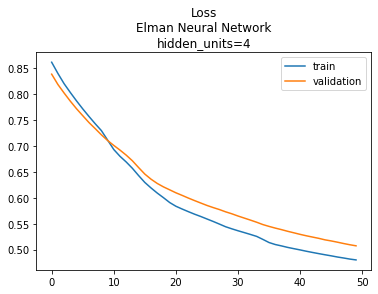

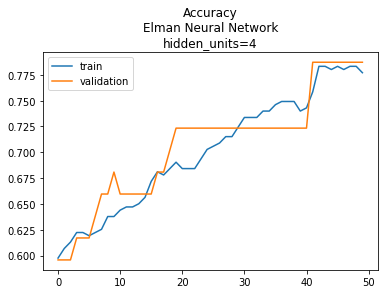

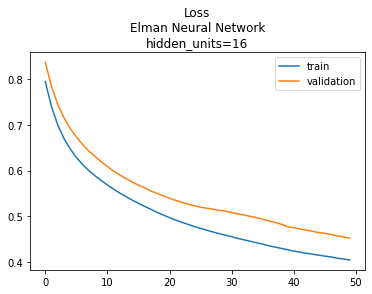

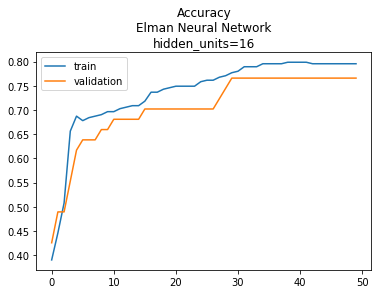

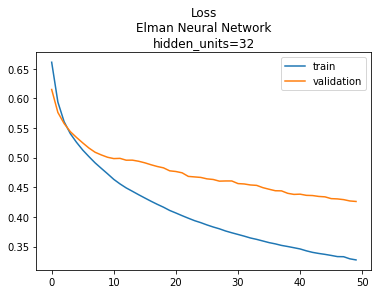

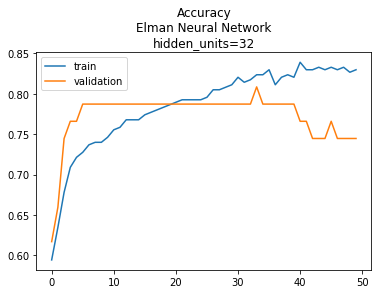

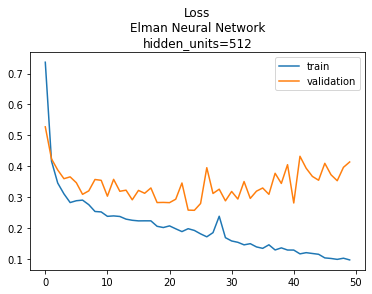

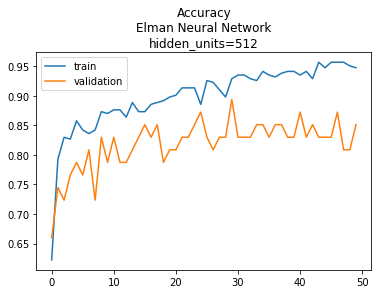

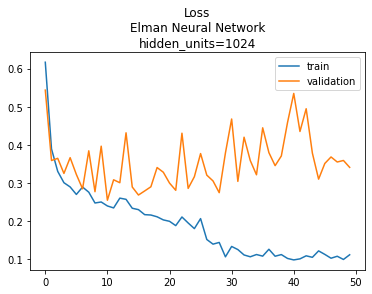

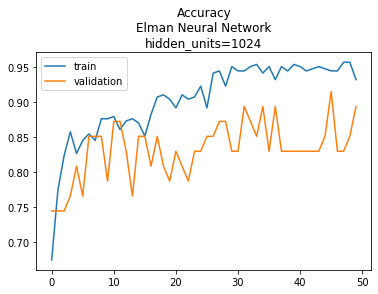

In [ ]:
results = dict()
for hunit in [4, 16, 32, 512, 1024]:
    elman_nn = elman_network_creator(hunit)
    history = elman_nn.fit(xtrain, ytrain, validation_data=(xval, yval), epochs=50, batch_size=2, verbose=0)
    history.history['test_loss'], history.history['test_acc'] = elman_nn.evaluate(xtest, ytest, verbose=0)
    visualize_result(history, params=f'Elman Neural Network\nhidden_units={hunit}', path='q1/elman')
    results[hunit] = history

In [ ]:
tabularize_result(results)

hunits	|   train loss	|   train acc	|   val loss	|   val acc	|   test loss	|   test acc	|
4	|	0.48	|	0.78	|	0.51	|	0.79	|	0.59	|	0.71	|
16	|	0.41	|	0.80	|	0.45	|	0.77	|	0.49	|	0.74	|
32	|	0.33	|	0.83	|	0.43	|	0.74	|	0.37	|	0.81	|
512	|	0.10	|	0.95	|	0.41	|	0.85	|	0.48	|	0.86	|
1024	|	0.11	|	0.93	|	0.34	|	0.89	|	0.51	|	0.81	|


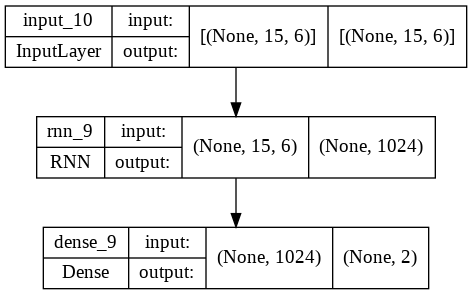

In [ ]:
tf.keras.utils.plot_model(elman_nn, to_file='images/q1/elman/architecture.png', show_shapes=True)

## Jordan Neural Network

In [11]:
class JordanCell(keras.layers.Layer):
      def __init__(self, units, **kwargs):
          self.units = units
          self.state_size = 2
          super(JordanCell, self).__init__(**kwargs)

      def build(self, input_shape):
          self.hidden_kernel = self.add_weight(shape=(input_shape[-1], self.units), initializer='glorot_uniform',
                                               regularizer=None, constraint=None)
          self.bias = self.add_weight(shape=(self.units,), initializer='zeros',
                                      regularizer=None, constraint=None)
          self.recurrent_kernel = self.add_weight(shape=(2, self.units), initializer='orthogonal', 
                                                  regularizer=None, constraint=None)
          self.output_kernel = self.add_weight(shape=(self.units, 2), initializer='uniform',
                                               regularizer=None, constraint=None)
          self.built = True

      def call(self, inputs, states):
          prev_output = states[0]
          h = backend.bias_add(backend.dot(inputs, self.hidden_kernel), self.bias)
          hidden_output = backend.tanh(h + backend.dot(prev_output, self.recurrent_kernel))
          output = backend.softmax(backend.dot(hidden_output, self.output_kernel))
          return output, [output]

In [12]:
def jordan_network_creator(hunit):
    jcell = JordanCell(hunit)
    x = keras.Input((15, 6))
    y = keras.layers.RNN(jcell)

    preds = y(x)

    jordan_nn = keras.Model(x, preds)
    jordan_nn.compile(optimizer=tf.keras.optimizers.Adam(1e-4),
                    loss='sparse_categorical_crossentropy',
                    metrics=['acc'])
    return jordan_nn

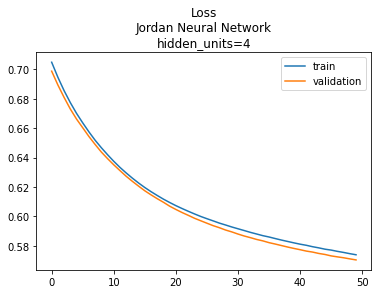

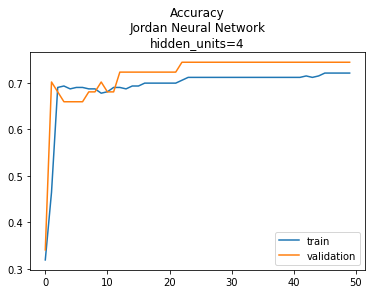

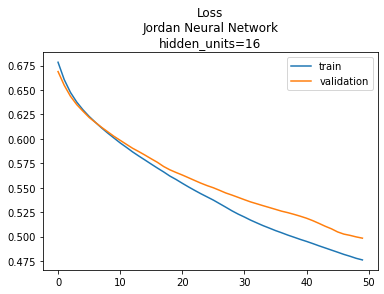

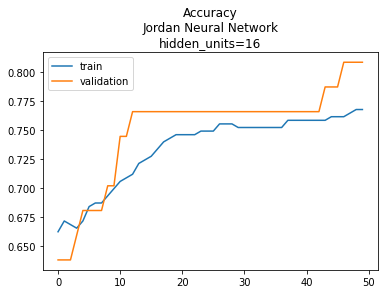

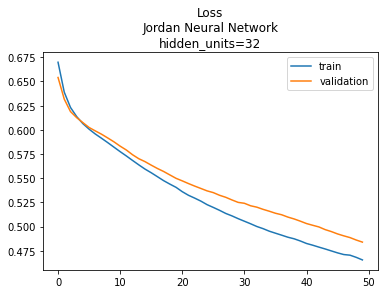

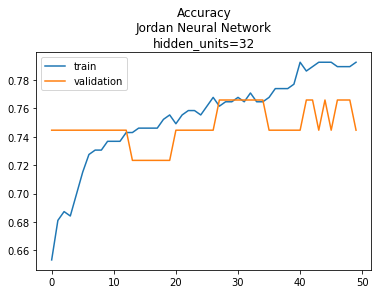

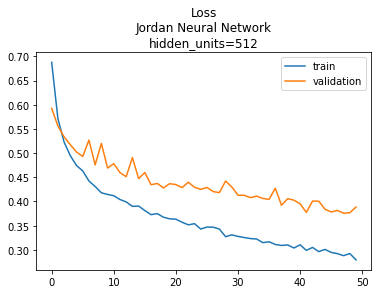

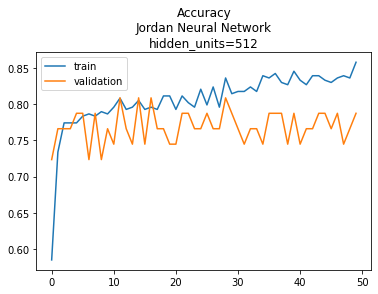

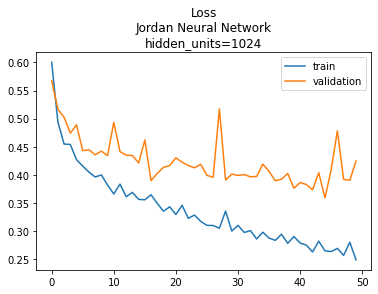

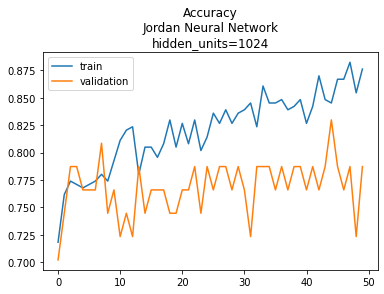

In [ ]:
results = dict()
for hunit in [4, 16, 32, 512, 1024]:
    jordan_nn = jordan_network_creator(hunit)
    history = jordan_nn.fit(xtrain, ytrain, validation_data=(xval, yval), epochs=50, batch_size=2, verbose=0)
    history.history['test_loss'], history.history['test_acc'] = jordan_nn.evaluate(xtest, ytest, verbose=0)
    visualize_result(history, params=f'Jordan Neural Network\nhidden_units={hunit}', path='q1/jordan')
    results[hunit] = history

In [ ]:
tabularize_result(results)

hunits	|   train loss	|   train acc	|   val loss	|   val acc	|   test loss	|   test acc	|
4	|	0.57	|	0.72	|	0.57	|	0.74	|	0.59	|	0.68	|
16	|	0.48	|	0.77	|	0.50	|	0.81	|	0.48	|	0.74	|
32	|	0.47	|	0.79	|	0.48	|	0.74	|	0.49	|	0.74	|
512	|	0.28	|	0.86	|	0.39	|	0.79	|	0.35	|	0.82	|
1024	|	0.25	|	0.88	|	0.42	|	0.79	|	0.35	|	0.77	|


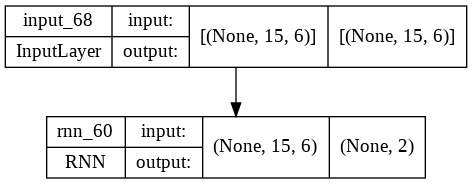

In [ ]:
tf.keras.utils.plot_model(jordan_nn, to_file='images/q1/jordan/architecture.png', show_shapes=True)

# Question 2

## Model Ensembler

In [13]:
def modeleEnsembler(hidden_models):
    inputs = keras.layers.Input((15,6))
    hidden_outputs = [model(inputs) for model in hidden_models] 
    predictions = keras.layers.Average()(hidden_outputs)

    ensemble_model = keras.Model(inputs=inputs, outputs=predictions)
    return ensemble_model

In [14]:
def modelFactory(config, verbose=0):
    stored_models = list()
    for spec in config:
        model, xtrain, ytrain, xval, yval = spec
        model.fit(xtrain, ytrain, validation_data=(xval, yval), epochs=50,
                    batch_size=2, verbose=verbose)
        stored_models.append(model)

    final_model = modeleEnsembler(stored_models)
    final_model.compile(optimizer=tf.keras.optimizers.Adam(1e-4),
                        loss='sparse_categorical_crossentropy',
                        metrics=['acc'])
    return final_model

In [15]:
def resultFactory(configs, verbose=0):
    print('\tdesc\t|\ttrain loss\t|\ttrain accu\t|\tval loss\t|\tval accur \t|\ttest loss\t|\ttest accu\t|')
    for config in configs:
        desc, details = config
        model = modelFactory(details, verbose)

        print(f'{desc}\t|', end='')
        for (x, y) in [(xtrain, ytrain), (xval, yval), (xtest, ytest)]:
            loss, acc = model.evaluate(x,y, verbose=0)
            print(f'\t{loss:.2f}\t\t|\t{acc:.2f}\t\t|', end='')
        print()

## Common Dataset

### Pure Elman

In [ ]:
configs = [
    ['5 Elman(4)', [[elman_network_creator(4), xtrain, ytrain, xval, yval]]*5],
    ['5 Elman(32)', [[elman_network_creator(32), xtrain, ytrain, xval, yval]]*5],
    ['5 Elman(1024)', [[elman_network_creator(1024), xtrain, ytrain, xval, yval]]*5],
    ['Elman(4), Elman(1024)', [[elman_network_creator(4), xtrain, ytrain, xval, yval], [elman_network_creator(1024), xtrain, ytrain, xval, yval]]],
    ['Elman(4), Elman(16), Elman(32), Elman(512), Elman(1024)', [[elman_network_creator(4), xtrain, ytrain, xval, yval], [elman_network_creator(16), xtrain, ytrain, xval, yval], [elman_network_creator(32), xtrain, ytrain, xval, yval], [elman_network_creator(512), xtrain, ytrain, xval, yval], [elman_network_creator(1024), xtrain, ytrain, xval, yval]]],
]
resultFactory(configs)

	desc	|	train loss	|	train accu	|	val loss	|	val accur 	|	test loss	|	test accu	|
5 Elman(4)	|	0.47		|	0.74		|	0.51		|	0.77		|	0.56		|	0.68		|
5 Elman(32)	|	0.20		|	0.92		|	0.30		|	0.81		|	0.36		|	0.77		|
5 Elman(1024)	|	0.06		|	0.97		|	0.80		|	0.85		|	1.00		|	0.82		|
Elman(4), Elman(1024)	|	0.25		|	0.96		|	0.38		|	0.85		|	0.41		|	0.83		|
Elman(4), Elman(16), Elman(32), Elman(512), Elman(1024)	|	0.27		|	0.96		|	0.38		|	0.89		|	0.40		|	0.82		|


### Pure Jordan

In [ ]:
configs = [
    ['5 Jordan(4)', [[jordan_network_creator(4), xtrain, ytrain, xval, yval]]*5],
    ['5 Jordan(32)', [[jordan_network_creator(32), xtrain, ytrain, xval, yval]]*5],
    ['5 Jordan(1024)', [[jordan_network_creator(1024), xtrain, ytrain, xval, yval]]*5],
    ['Jordan(4), Jordan(1024)', [[jordan_network_creator(4), xtrain, ytrain, xval, yval], [jordan_network_creator(1024), xtrain, ytrain, xval, yval]]],
    ['Jordan(4), Jordan(16), Jordan(32), Jordan(512), Jordan(1024)', [[jordan_network_creator(4), xtrain, ytrain, xval, yval], [jordan_network_creator(16), xtrain, ytrain, xval, yval], [jordan_network_creator(32), xtrain, ytrain, xval, yval], [jordan_network_creator(512), xtrain, ytrain, xval, yval], [jordan_network_creator(1024), xtrain, ytrain, xval, yval]]],
]
resultFactory(configs)

	desc	|	train loss	|	train accu	|	val loss	|	val accur 	|	test loss	|	test accu	|
5 Jordan(4)	|	0.48		|	0.81		|	0.49		|	0.81		|	0.55		|	0.74		|
5 Jordan(32)	|	0.28		|	0.86		|	0.39		|	0.77		|	0.35		|	0.83		|
5 Jordan(1024)	|	0.14		|	0.94		|	0.31		|	0.85		|	0.40		|	0.83		|
Jordan(4), Jordan(1024)	|	0.40		|	0.83		|	0.45		|	0.81		|	0.44		|	0.80		|
Jordan(4), Jordan(16), Jordan(32), Jordan(512), Jordan(1024)	|	0.38		|	0.84		|	0.43		|	0.79		|	0.42		|	0.78		|


### Jordan + Elman

In [ ]:
configs = [
    ['2 Elman(4) + 2 Jordan(4)', [[elman_network_creator(4), xtrain, ytrain, xval, yval], [elman_network_creator(4), xtrain, ytrain, xval, yval], [jordan_network_creator(4), xtrain, ytrain, xval, yval], [jordan_network_creator(4), xtrain, ytrain, xval, yval]]],
    ['2 Elman(32) + 2 Jordan (32)', [[elman_network_creator(32), xtrain, ytrain, xval, yval], [elman_network_creator(32), xtrain, ytrain, xval, yval], [jordan_network_creator(32), xtrain, ytrain, xval, yval], [jordan_network_creator(32), xtrain, ytrain, xval, yval]]],
    ['2 Elman(1024) + 2 Jordan (1024)', [[elman_network_creator(1024), xtrain, ytrain, xval, yval], [elman_network_creator(1024), xtrain, ytrain, xval, yval], [jordan_network_creator(1024), xtrain, ytrain, xval, yval], [jordan_network_creator(1024), xtrain, ytrain, xval, yval]]],
    ['Elman(4) + Elman(1024) + Jordan(4) + Jordan (1024)', [[elman_network_creator(4), xtrain, ytrain, xval, yval], [elman_network_creator(1024), xtrain, ytrain, xval, yval], [jordan_network_creator(4), xtrain, ytrain, xval, yval], [jordan_network_creator(1024), xtrain, ytrain, xval, yval]]],
]   
resultFactory(configs)

	desc	|	train loss	|	train accu	|	val loss	|	val accur 	|	test loss	|	test accu	|
2 Elman(4) + 2 Jordan(4)	|	0.52		|	0.77		|	0.53		|	0.77		|	0.54		|	0.76		|
2 Elman(32) + 2 Jordan (32)	|	0.36		|	0.80		|	0.40		|	0.74		|	0.46		|	0.75		|
2 Elman(1024) + 2 Jordan (1024)	|	0.15		|	0.95		|	0.30		|	0.89		|	0.35		|	0.84		|
Elman(4) + Elman(1024) + Jordan(4) + Jordan (1024)	|	0.32		|	0.93		|	0.39		|	0.79		|	0.42		|	0.85		|


## Uncommon Dataset

### Dataset Splitter

In [20]:
def dataset_splitter(xtrain, ytrain, xval, yval, n_split):
    train_ind = shuffle(list(range(len(xtrain))), random_state=42)
    train_ind_splts = np.array_split(train_ind, n_split)
    val_ind = shuffle(list(range(len(xval))), random_state=42)
    val_ind_splts = np.array_split(val_ind, n_split)
    ds = list()
    for n in range(n_split):
        ds.append([xtrain[train_ind_splts[n]],
                   ytrain[train_ind_splts[n]],
                   xval[val_ind_splts[n]],
                   yval[val_ind_splts[n]]
        ])
    return ds

### Pure Elman

In [ ]:
ds2 = dataset_splitter(xtrain, ytrain, xval, yval, n_split=2)
ds5 = dataset_splitter(xtrain, ytrain, xval, yval, n_split=5)

configs = [
    ['5 Elman(4)', [[elman_network_creator(4), *ds5[0]], [elman_network_creator(4), *ds5[1]], [elman_network_creator(4), *ds5[2]], [elman_network_creator(4), *ds5[3]], [elman_network_creator(4), *ds5[4]]]],
    ['5 Elman(32)', [[elman_network_creator(32), *ds5[0]], [elman_network_creator(32), *ds5[1]], [elman_network_creator(32), *ds5[2]], [elman_network_creator(32), *ds5[3]], [elman_network_creator(32), *ds5[4]]]],
    ['5 Elman(1024)', [[elman_network_creator(1024), *ds5[0]], [elman_network_creator(1024), *ds5[1]], [elman_network_creator(1024), *ds5[2]], [elman_network_creator(1024), *ds5[3]], [elman_network_creator(1024), *ds5[4]]]],
    ['Elman(4), Elman(1024)', [[elman_network_creator(4), *ds2[0]], [elman_network_creator(1024), *ds2[1]]]],
    ['Elman(4), Elman(16), Elman(32), Elman(512), Elman(1024)', [[elman_network_creator(4), *ds5[0]], [elman_network_creator(16), *ds5[1]], [elman_network_creator(32), *ds5[2]], [elman_network_creator(512), *ds5[3]], [elman_network_creator(1024), *ds5[4]]]],
]
resultFactory(configs, verbose=0)

	desc	|	train loss	|	train accu	|	val loss	|	val accur 	|	test loss	|	test accu	|
5 Elman(4)	|	0.60		|	0.67		|	0.61		|	0.66		|	0.58		|	0.70		|
5 Elman(32)	|	0.51		|	0.77		|	0.52		|	0.74		|	0.51		|	0.77		|
5 Elman(1024)	|	0.36		|	0.83		|	0.38		|	0.77		|	0.44		|	0.75		|
Elman(4), Elman(1024)	|	0.39		|	0.87		|	0.40		|	0.81		|	0.44		|	0.84		|
Elman(4), Elman(16), Elman(32), Elman(512), Elman(1024)	|	0.48		|	0.78		|	0.47		|	0.74		|	0.49		|	0.82		|


### Pure Jordan

In [ ]:
ds2 = dataset_splitter(xtrain, ytrain, xval, yval, n_split=2)
ds5 = dataset_splitter(xtrain, ytrain, xval, yval, n_split=5)

configs = [
    ['5 Jordan(4)', [[jordan_network_creator(4), *ds5[0]], [jordan_network_creator(4), *ds5[1]], [jordan_network_creator(4), *ds5[2]], [jordan_network_creator(4), *ds5[3]], [jordan_network_creator(4), *ds5[4]]]],
    ['5 Jordan(32)', [[jordan_network_creator(4), *ds5[0]], [jordan_network_creator(4), *ds5[1]], [jordan_network_creator(4), *ds5[2]], [jordan_network_creator(4), *ds5[3]], [jordan_network_creator(4), *ds5[4]]]],
    ['5 Jordan(1024)', [[jordan_network_creator(4), *ds5[0]], [jordan_network_creator(4), *ds5[1]], [jordan_network_creator(4), *ds5[2]], [jordan_network_creator(4), *ds5[3]], [jordan_network_creator(4), *ds5[4]]]],
    ['Jordan(4), Jordan(1024)', [[jordan_network_creator(4), *ds2[0]], [jordan_network_creator(1024), *ds2[1]]]],
    ['Jordan(4), Jordan(16), Jordan(32), Jordan(512), Jordan(1024)', [[jordan_network_creator(4), *ds5[0]], [jordan_network_creator(4), *ds5[1]], [jordan_network_creator(4), *ds5[2]], [jordan_network_creator(4), *ds5[3]], [jordan_network_creator(4), *ds5[4]]]],
]
resultFactory(configs, verbose=0)

	desc	|	train loss	|	train accu	|	val loss	|	val accur 	|	test loss	|	test accu	|
5 Jordan(4)	|	0.64		|	0.67		|	0.65		|	0.66		|	0.64		|	0.70		|
5 Jordan(32)	|	0.64		|	0.70		|	0.64		|	0.68		|	0.64		|	0.74		|
5 Jordan(1024)	|	0.65		|	0.70		|	0.65		|	0.66		|	0.64		|	0.73		|
Jordan(4), Jordan(1024)	|	0.44		|	0.80		|	0.48		|	0.81		|	0.50		|	0.76		|
Jordan(4), Jordan(16), Jordan(32), Jordan(512), Jordan(1024)	|	0.65		|	0.68		|	0.65		|	0.66		|	0.65		|	0.72		|


### Jordan + Elman

In [ ]:
ds4 = dataset_splitter(xtrain, ytrain, xval, yval, n_split=4)
ds5 = dataset_splitter(xtrain, ytrain, xval, yval, n_split=5)

configs = [
    ['2 Elman(4) + 2 Jordan(4)', [[elman_network_creator(4), *ds4[0]], [elman_network_creator(4), *ds4[1]], [jordan_network_creator(4), *ds4[2]], [jordan_network_creator(4), *ds4[3]]]],
    ['2 Elman(32) + 2 Jordan (32)', [[elman_network_creator(32), *ds4[0]], [elman_network_creator(32), *ds4[1]], [jordan_network_creator(32), *ds4[2]], [jordan_network_creator(32), *ds4[3]]]],
    ['2 Elman(1024) + 2 Jordan (1024)', [[elman_network_creator(1024), *ds4[0]], [elman_network_creator(1024), *ds4[1]], [jordan_network_creator(1024), *ds4[2]], [jordan_network_creator(1024), *ds4[3]]]],
    ['Elman(4), Elman(1024) Jordan(4), Jordan(1024)', [[jordan_network_creator(4), *ds4[0]], [jordan_network_creator(1024), *ds4[1]], [elman_network_creator(4), *ds4[2]], [elman_network_creator(1024), *ds4[3]]]],
    ['3 Elman(32), 2 Jordan(1024)', [[elman_network_creator(32), *ds5[0]], [elman_network_creator(32), *ds5[1]], [elman_network_creator(32), *ds5[2]], [jordan_network_creator(1024), *ds5[3]], [jordan_network_creator(1024), *ds5[4]]]]
]
resultFactory(configs)

	desc	|	train loss	|	train accu	|	val loss	|	val accur 	|	test loss	|	test accu	|
2 Elman(4) + 2 Jordan(4)	|	0.60		|	0.71		|	0.63		|	0.68		|	0.60		|	0.72		|
2 Elman(32) + 2 Jordan (32)	|	0.53		|	0.77		|	0.57		|	0.70		|	0.55		|	0.76		|
2 Elman(1024) + 2 Jordan (1024)	|	0.34		|	0.85		|	0.40		|	0.79		|	0.44		|	0.76		|
Elman(4), Elman(1024) Jordan(4), Jordan(1024)	|	0.48		|	0.82		|	0.51		|	0.74		|	0.50		|	0.77		|
3 Elman(32), 2 Jordan(1024)	|	0.46		|	0.79		|	0.48		|	0.70		|	0.50		|	0.78		|


### Checking impact of number of sub network

In [29]:
ds2 = dataset_splitter(xtrain, ytrain, xval, yval, n_split=2)
ds4 = dataset_splitter(xtrain, ytrain, xval, yval, n_split=4)
ds8 = dataset_splitter(xtrain, ytrain, xval, yval, n_split=8)
ds16 = dataset_splitter(xtrain, ytrain, xval, yval, n_split=16)

configs = [
    ['2 * Elman(32)', [[elman_network_creator(32), *ds2[0]], [elman_network_creator(32), *ds2[1]]]],
    ['4 * Elman(32)', [[elman_network_creator(32), *ds4[0]], [elman_network_creator(32), *ds4[1]], [elman_network_creator(32), *ds4[2]], [elman_network_creator(32), *ds4[3]]]],
    ['8 * Elman(32)', [[elman_network_creator(32), *ds8[0]], [elman_network_creator(32), *ds8[1]], [elman_network_creator(32), *ds8[2]], [elman_network_creator(32), *ds8[3]], [elman_network_creator(32), *ds8[4]], [elman_network_creator(32), *ds8[5]], [elman_network_creator(32), *ds8[6]], [elman_network_creator(32), *ds8[7]]]],
    ['16 * Elman(32)', [[elman_network_creator(32), *ds16[0]], [elman_network_creator(32), *ds16[1]], [elman_network_creator(32), *ds16[2]], [elman_network_creator(32), *ds16[3]], [elman_network_creator(32), *ds16[4]], [elman_network_creator(32), *ds16[5]], [elman_network_creator(32), *ds16[6]], [elman_network_creator(32), *ds16[7]], [elman_network_creator(32), *ds16[8]], [elman_network_creator(32), *ds16[9]], [elman_network_creator(32), *ds16[10]], [elman_network_creator(32), *ds16[11]], [elman_network_creator(32), *ds16[12]], [elman_network_creator(32), *ds16[13]], [elman_network_creator(32), *ds16[14]], [elman_network_creator(32), *ds16[15]]]]
]
resultFactory(configs)

	desc	|	train loss	|	train accu	|	val loss	|	val accur 	|	test loss	|	test accu	|
2 * Elman(32)	|	0.38		|	0.81		|	0.43		|	0.72		|	0.49		|	0.74		|
4 * Elman(32)	|	0.46		|	0.77		|	0.52		|	0.70		|	0.54		|	0.75		|
8 * Elman(32)	|	0.54		|	0.74		|	0.56		|	0.70		|	0.58		|	0.73		|
16 * Elman(32)	|	0.59		|	0.72		|	0.60		|	0.68		|	0.60		|	0.72		|


In [30]:
ds2 = dataset_splitter(xtrain, ytrain, xval, yval, n_split=2)
ds4 = dataset_splitter(xtrain, ytrain, xval, yval, n_split=4)
ds8 = dataset_splitter(xtrain, ytrain, xval, yval, n_split=8)
ds16 = dataset_splitter(xtrain, ytrain, xval, yval, n_split=16)

configs = [
    ['2 * Jordan(32)', [[jordan_network_creator(32), *ds2[0]], [jordan_network_creator(32), *ds2[1]]]],
    ['4 * Jordan(32)', [[jordan_network_creator(32), *ds4[0]], [jordan_network_creator(32), *ds4[1]], [jordan_network_creator(32), *ds4[2]], [jordan_network_creator(32), *ds4[3]]]],
    ['8 * Jordan(32)', [[jordan_network_creator(32), *ds8[0]], [jordan_network_creator(32), *ds8[1]], [jordan_network_creator(32), *ds8[2]], [jordan_network_creator(32), *ds8[3]], [jordan_network_creator(32), *ds8[4]], [jordan_network_creator(32), *ds8[5]], [jordan_network_creator(32), *ds8[6]], [jordan_network_creator(32), *ds8[7]]]],
    ['16 * Jordan(32)', [[jordan_network_creator(32), *ds16[0]], [jordan_network_creator(32), *ds16[1]], [jordan_network_creator(32), *ds16[2]], [jordan_network_creator(32), *ds16[3]], [jordan_network_creator(32), *ds16[4]], [jordan_network_creator(32), *ds16[5]], [jordan_network_creator(32), *ds16[6]], [jordan_network_creator(32), *ds16[7]], [jordan_network_creator(32), *ds16[8]], [jordan_network_creator(32), *ds16[9]], [jordan_network_creator(32), *ds16[10]], [jordan_network_creator(32), *ds16[11]], [jordan_network_creator(32), *ds16[12]], [jordan_network_creator(32), *ds16[13]], [jordan_network_creator(32), *ds16[14]], [jordan_network_creator(32), *ds16[15]]]]
]
resultFactory(configs)

	desc	|	train loss	|	train accu	|	val loss	|	val accur 	|	test loss	|	test accu	|
2 * Jordan(32)	|	0.50		|	0.77		|	0.55		|	0.70		|	0.56		|	0.72		|
4 * Jordan(32)	|	0.55		|	0.75		|	0.58		|	0.68		|	0.57		|	0.73		|
8 * Jordan(32)	|	0.59		|	0.72		|	0.60		|	0.68		|	0.59		|	0.75		|
16 * Jordan(32)	|	0.62		|	0.70		|	0.63		|	0.68		|	0.61		|	0.75		|
